# Import required libraries

In [1]:
import torch
import os
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from sentence_transformers import SimilarityFunction
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# Test CUDA

In [2]:
# Test CUDA device
if torch.cuda.is_available():
  print("CUDA is available!")
  print("Device count:", torch.cuda.device_count())
  print("Current device index:", torch.cuda.current_device())
  print("Current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
  device = "cuda"
else:
  print("CUDA is not available!")
  device = "cpu"

CUDA is available!
Device count: 2
Current device index: 0
Current device name: NVIDIA GeForce RTX 3090


# Login to Huggingface Hub

In [3]:
HF_TOKEN = os.getenv("HF_TOKEN")
login(token=HF_TOKEN, add_to_git_credential=False, new_session=False)

# Load model
Có thể thay đổi model khác tuỳ vào sở thích, mình dùng mặc định [gemma-2  2 tỉ params](https://huggingface.co/google/gemma-2-2b-it) đã được instruct của Google.

In [4]:
# Load model directly
model_name = "google/gemma-2-2b-it"
# model_name = "Qwen/Qwen2.5-7B"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Test model

In [5]:
prompt = "Xin chào!"
messages = [
    # {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful and harmless assistant"}, # Used for Qwen2.5-7B
    {"role": "user", "content": prompt},
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=2048,
)
generated_text = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]
response = tokenizer.batch_decode(generated_text, skip_special_tokens=True)[0]
print(response)

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Xin chào! 👋  

Bạn có muốn tôi giúp gì không? 😊 



# Initialize Vector database
Có nhiều model embedding dùng cho tiếng việt khá ổn, sau khi test vài cái thì mình thấy [embedding](https://huggingface.co/dangvantuan/vietnamese-document-embedding) của anh [dangvantuan](https://huggingface.co/dangvantuan) dùng tốt nhất cho các văn bản tiếng việt lớn khi token tối đa lên tới 8192.

In [6]:
# embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
embedding_model = "dangvantuan/vietnamese-document-embedding"
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model,
    multi_process=True,
    model_kwargs={
        "similarity_fn_name": SimilarityFunction.EUCLIDEAN,
        "device": device,
        "trust_remote_code": True,
        },
    encode_kwargs={
        "normalize_embeddings": True,
        },
    show_progress=True,
)

DATA_PATH = "./data"
CHROMA_DB_PATH = "./chroma"
DOC_SEPARATOR = [
    "\n\n",
    "\n",
    ".\n",
    ";\n",
] # Add more separators depending on the document's structure

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    try:
        # urllib.request.urlretrieve("https://aclanthology.org/2020.findings-emnlp.92.pdf", f"{DATA_PATH}/PhoBERT - Pretrained Language Models for Vietnamese.pdf")
        # urllib.request.urlretrieve("https://arxiv.org/pdf/2408.00118", f"{DATA_PATH}/Gemma 2 - Improving Open Language Models at a Practical Size.pdf")
        # urllib.request.urlretrieve("https://arxiv.org/pdf/2403.08295", f"{DATA_PATH}/Gemma - Open Models Based on Gemini Research and Technology.pdf")
        # urllib.request.urlretrieve("https://arxiv.org/pdf/2412.15115", f"{DATA_PATH}/Qwen2.5 - Technical Report.pdf")
        urllib.request.urlretrieve("https://datafiles.chinhphu.vn/cpp/files/vbpq/2024/9/36-2024-qh15.pdf", f"{DATA_PATH}/LUẬT TRẬT TỰ, AN TOÀN GIAO THÔNG ĐƯỜNG BỘ.pdf")
        urllib.request.urlretrieve("https://datafiles.chinhphu.vn/cpp/files/vbpq/2024/9/36-2024-qh15_tiep.pdf", f"{DATA_PATH}/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf")
    except Exception as e:
        print(f"Failed to download the file: {e}")
if not os.path.exists(CHROMA_DB_PATH):
    os.makedirs(CHROMA_DB_PATH)

# Load document and split into chunks
document = PyPDFDirectoryLoader(DATA_PATH).load()
chunks = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer=AutoTokenizer.from_pretrained(model_name),
    chunk_size=256, # Should be less than embedding model's max_seq_length
    chunk_overlap=32, # It is recommend to set to 10-15% of chunk_size
    strip_whitespace=True,
    # is_separator_regex=False,
    separators=DOC_SEPARATOR,
).split_documents(document)

# Create database
db = Chroma(collection_name="papers", persist_directory=CHROMA_DB_PATH, embedding_function=embeddings)

# Assign unique ID to each chunk
last_source_id = None
current_chunk_index = 0

for chunk in chunks:
    source = chunk.metadata["source"]
    page = chunk.metadata["page"]
    current_source_id = f"{source}:{page}"

    if current_source_id == last_source_id:
        current_chunk_index += 1
    else:
        current_chunk_index = 0

    chunk_id = f"{current_source_id}:{current_chunk_index}"
    last_source_id = current_source_id

    chunk.metadata["chunk_id"] = chunk_id


# Get existed chunks in database
existed_chunks = db.get(include=[])
existed_ids = set(existed_chunks["ids"])
print(f"Number of existed chunks in Chroma DB: {len(existed_ids)}")

# Add new chunks to database
new_chunks = [chunk for chunk in chunks if chunk.metadata["chunk_id"] not in existed_ids]
print(f"Number of new chunks to add: {len(new_chunks)}")

if len(new_chunks):
    print("Adding new chunks to Chroma DB...")
    new_chunks_ids = [chunk.metadata["chunk_id"] for chunk in new_chunks]
    db.add_documents(new_chunks, ids=new_chunks_ids, show_progress=True)
else:
    print("No new chunks to add.")

Number of existed chunks in Chroma DB: 0
Number of new chunks to add: 318
Adding new chunks to Chroma DB...


# Visuallization of token's counts of new chunks

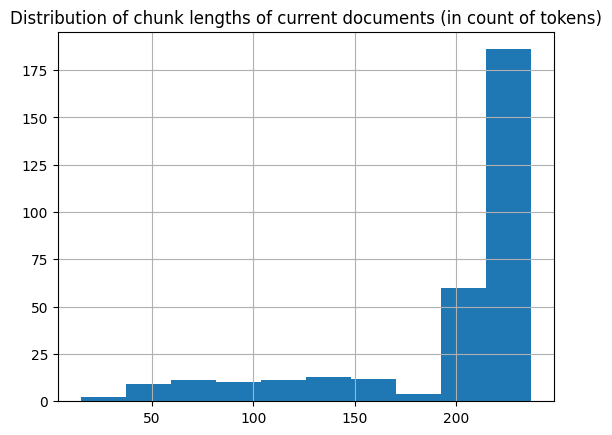

In [7]:
chunk_lengths = [len(tokenizer.encode(chunk.page_content)) for chunk in chunks]
fig = pd.Series(chunk_lengths).hist()
plt.title("Distribution of chunk lengths of current documents (in count of tokens)")
plt.show()

# Main question
Thay đổi câu hỏi rồi chạy lại code phần "Search with RAG" để gen ra câu trả lời mới

In [8]:
question = "Xe gắn máy là xe gì?"

# Search with RAG
Mình dùng [phoBERT base v2](https://huggingface.co/vinai/phobert-base-v2) để reranking để bằng cross-encoder cho tập các đoạn văn bản đã truy vấn từ chromadb, tăng độ chính xác tìm văn bản liên quan đến câu hỏi trong database.

In [9]:
# Use phoBERT model for reranking
# bert_model = "colbert-ir/colbertv2.0"
bert_model = "vinai/phobert-base-v2"
bert = HuggingFaceCrossEncoder(
    model_name=bert_model,
    model_kwargs={
        "device": device,
        }
    )
retrieved_chunks = db.as_retriever(search_kwargs={"k":50})
compressor = CrossEncoderReranker(model=bert, top_n=15)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retrieved_chunks,
)
retrieved_docs = compression_retriever.invoke(question)

# Get source of retrieved chunks
source = [doc.metadata.get("chunk_id", None) for doc in retrieved_docs]

# Prepare prompt for generation
context = "".join([doc.page_content for doc in retrieved_docs])
PROMPT_TEMPLATE = [
#     {
#         "role": "system",
#         "content": """You are Qwen, created by Alibaba Cloud. You are a helpful and harmless assistant.
# Using the information contained in the context,give a comprehensive answer to the question.
# Respond only to the question asked, response should be concise and relevant to the question.
# Provide the number of the source document when relevant.
# If the answer cannot be deduced from the context, do not give an answer."""
#     }, # This role is for Qwen2.5
    {
        "role": "user",
        "content": f"""Answer the question based only on the following context:
{context}

---------------------------------------------------------------
Now, based on the context above, answer the following question:
{question}
"""
    }
]
PROMPT_TEMPLATE_VN = [
#     {
#         "role": "system",
#         "content": """Bạn là Qwen, được tạo ra bởi Alibaba Cloud. Bạn là một trợ lý hữu ích và vô hại.
# Dựa vào thông tin chứa trong ngữ cảnh, hãy trả lời câu hỏi một cách toàn diện.
# Chỉ trả lời câu hỏi được đặt ra, phản hồi nên ngắn gọn và liên quan đến câu hỏi.
# Cung cấp số của tài liệu nguồn khi cần thiết.
# Nếu câu trả lời không thể suy luận từ ngữ cảnh, đừng trả lời."""
#     }, # This role is for Qwen2.5
    {
        "role": "user",
        "content": f"""Trả lời câu hỏi chỉ dựa trên nội dung sau:
{context}

--------------------------------------------------------
Bây giờ, dựa vào nội dung trên, hãy trả lời câu hỏi sau:
{question}
"""
    }
]
rag_prompt_template = tokenizer.apply_chat_template(PROMPT_TEMPLATE_VN, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([rag_prompt_template], return_tensors="pt").to(model.device)
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=2048,
)
generated_text = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]
response = tokenizer.batch_decode(generated_text, skip_special_tokens=True)[0]
print(f"{response}\n------------\nNguồn: {source}\nChú thích nguồn: (văn bản):(số trang):(số đoạn)")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Xe gắn máy là xe có hai hoặc ba bánh chạy bằng động cơ, được thiết kế, sản xuất để hoạt động trên đường bộ, có vận tốc thiết kế không lớn hơn 50 km/h. 

------------
Nguồn: ['data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:5:3', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:28:3', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:7:3', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:23:3', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:27:3', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:8:0', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:28:2', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:27:2', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:24:0', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:8:1', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:14:3', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:20:3', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:9:1', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:13:1', 'data/VĂN BẢN QUY PHẠM PHÁP LUẬT.pdf:31:0']
Chú thích nguồn: (văn bản):(số trang):(số đoạn)
